In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [42]:
# Read all data files of one category.
import os

trajectories_per_category = {}
for category in ['alive', 'fibro', 'plastic']:
    data_dir = 'data/JulianTrajs/' + category
    trajectories = []  # dimensions: trajectory index -> time step -> coordinate (x, y, z)
    for filename in os.listdir(data_dir):
        print filename, '->',
        trajectory = np.genfromtxt(os.path.join(data_dir, filename))
        print trajectory.shape[0], 'time steps'
        trajectories.append(trajectory)
    trajectories = np.array(trajectories)
    trajectories_per_category[category] = trajectories

cell001.dat -> 577 time steps
cell002.dat -> 577 time steps
cell003.dat -> 577 time steps
cell004.dat -> 577 time steps
cell005.dat -> 577 time steps
cell006.dat -> 577 time steps
cell007.dat -> 577 time steps
cell008.dat -> 577 time steps
cell009.dat -> 577 time steps
cell010.dat -> 577 time steps
cell011.dat -> 577 time steps
cell012.dat -> 577 time steps
cell013.dat -> 577 time steps
cell014.dat -> 577 time steps
cell015.dat -> 577 time steps
cell016.dat -> 577 time steps
cell017.dat -> 577 time steps
cell018.dat -> 577 time steps
cell019.dat -> 577 time steps
cell020.dat -> 577 time steps
cell021.dat -> 577 time steps
cell022.dat -> 577 time steps
cell023.dat -> 577 time steps
cell024.dat -> 577 time steps
cell025.dat -> 577 time steps
cell026.dat -> 577 time steps
cell027.dat -> 577 time steps
cell028.dat -> 577 time steps
cell029.dat -> 577 time steps
cell030.dat -> 577 time steps
cell031.dat -> 577 time steps
cell032.dat -> 577 time steps
cell033.dat -> 577 time steps
cell034.da

In [43]:
# Take every second time step from 'alive' and every fifth time step from 'fibro' and 'plastic' 
# to make the trajectories have the same time step.
trajectories_per_category['alive'] = trajectories_per_category['alive'][:, ::2]
trajectories_per_category['fibro'] = trajectories_per_category['fibro'][:, ::5]
trajectories_per_category['plastic'] = trajectories_per_category['plastic'][:, ::5]

In [68]:
def shuffle_together(*args):
    rng_state = np.random.get_state()
    for arg in args:
        np.random.shuffle(arg)
        np.random.set_state(rng_state)

In [47]:
len_mini_trajectories = 50
step = 10

mini_trajectories = []
classes = []
category_to_target = {'alive': 0, 'fibro': 1, 'plastic': 2}
target_to_category = {0: 'alive', 1: 'fibro', 2: 'plastic'}

# TODO: Make sure that it creates ~ the same number of mini trajectories for each category (currently, there is way more data for plastic).

for category, trajectories in trajectories_per_category.items():
    
    len_before = len(mini_trajectories)
    
    # Normalize trajectories to [-1, 1] for the LSTM network (it outputs values between -1 and 1 by default).
    min_value = np.min(trajectories)
    max_value = np.max(trajectories)
    normalized_trajectories = np.interp(trajectories, [min_value, max_value], [-1., 1.])

    for trajectory in normalized_trajectories:
        for i in range(0, len(trajectory) - len_mini_trajectories, step):
            mini_trajectories.append(trajectory[i:i+len_mini_trajectories] - trajectory[i])  # Set start of mini trajectory to origin.
            classes.append(category_to_target[category])
            
    print 'Created {} mini trajectories for {}'.format(len(mini_trajectories) - len_before, category)
       

mini_trajectories = np.array(mini_trajectories)
classes = np.array(classes)
from keras.utils import np_utils
targets = np_utils.to_categorical(classes, 3)

shuffle_together(mini_trajectories, classes, targets)

print 'Created', len(mini_trajectories), 'mini trajectories total'

Created 1035 mini trajectories for fibro
Created 1560 mini trajectories for alive
Created 2655 mini trajectories for plastic
Created 5250 mini trajectories total


In [48]:
# TODO: Split training/test.
mini_trajectories

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.00399933, -0.01145147,  0.        ],
        [ 0.02884963, -0.00239633,  0.        ],
        ..., 
        [ 0.26138632, -0.04471941,  0.        ],
        [ 0.25325798,  0.0128414 ,  0.        ],
        [ 0.25707804,  0.02637753,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [-0.02360942, -0.01510407, -0.0235096 ],
        [-0.04204898, -0.03057164, -0.01908222],
        ..., 
        [ 0.04345951,  0.05190568, -0.04920935],
        [ 0.0343274 ,  0.04655328, -0.04120042],
        [ 0.03562504,  0.04660606, -0.04552723]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.00810269,  0.00319414,  0.00249495],
        [ 0.01043189, -0.00195982,  0.01059998],
        ..., 
        [-0.0161205 ,  0.02173679,  0.09060362],
        [-0.02093891,  0.00573233,  0.10865872],
        [ 0.00073113,  0.02162329,  0.07915218]],

       ..., 
       [[ 0.        ,  0.        ,  0.        ],
        

In [49]:
# Set up the network.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

model = Sequential()

model.add(LSTM(input_dim=3, output_dim=10, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(output_dim=10, return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(output_dim=3))
model.add(Activation('softmax'))

# TODO: Add Dropout and more LSTM layers. 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [66]:
# TODO: Traing with mini trajectories of different lengths and compare the network performance. 
# TODO: Try training with velocities/displacements. 
model.fit(mini_trajectories, targets, batch_size=30, nb_epoch=10, verbose=1, show_accuracy=True, validation_split=0.1)

Train on 4725 samples, validate on 525 samples
Epoch 1/10
4725/4725 [==============================] - 9s - loss: 0.9578 - acc: 0.5490 - val_loss: 0.9722 - val_acc: 0.5581
Epoch 2/10
4725/4725 [==============================] - 9s - loss: 0.9538 - acc: 0.5547 - val_loss: 0.9701 - val_acc: 0.5448
Epoch 3/10
4725/4725 [==============================] - 9s - loss: 0.9497 - acc: 0.5568 - val_loss: 0.9680 - val_acc: 0.5200
Epoch 4/10
4725/4725 [==============================] - 9s - loss: 0.9489 - acc: 0.5572 - val_loss: 0.9563 - val_acc: 0.5581
Epoch 5/10
4725/4725 [==============================] - 10s - loss: 0.9454 - acc: 0.5604 - val_loss: 0.9553 - val_acc: 0.5410
Epoch 6/10
4725/4725 [==============================] - 10s - loss: 0.9458 - acc: 0.5547 - val_loss: 0.9644 - val_acc: 0.5238
Epoch 7/10
4725/4725 [==============================] - 10s - loss: 0.9438 - acc: 0.5587 - val_loss: 0.9638 - val_acc: 0.5333
Epoch 8/10
4725/4725 [==============================] - 10s - loss: 0.9425 

Class 0: 0.271820813417
Class 1: 0.183867424726
Class 2: 0.544311761856
Is Class 0


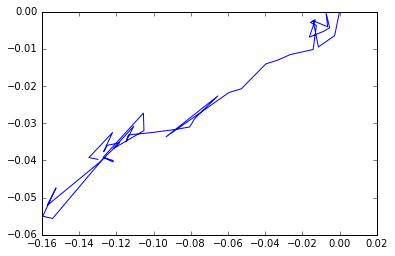

In [61]:
# Test on a random mini trajectory.
i = np.random.randint(len(mini_trajectories))
plt.plot(mini_trajectories[i, :, 0], mini_trajectories[i, :, 1])
probabilities, = model.predict(mini_trajectories[i:i+1])
for cat, prob in enumerate(probabilities):
    print 'Class {}: {}'.format(cat, prob)
    
print 'Is Class', classes[i]

In [67]:
for which_class in [0, 1, 2]:
    predicted = model.predict_classes(mini_trajectories[classes == which_class])
    class_acc = 1. * np.sum(predicted == which_class) / len(predicted)
    print 'Accuracy for class {}: {}'.format(which_class, class_acc)

1560/1560 [==============================] - 0s     
Accuracy for class 0: 0.562820512821
1035/1035 [==============================] - 0s     
Accuracy for class 1: 0.0
2655/2655 [==============================] - 1s     
Accuracy for class 2: 0.803766478343


In [ ]:
# TODO: Predict classes for mini trajectories with different lengths and see how the probabilities improve for longer samples.